# Model 2

ANN model as in modelID A010 as in Walsh et al. (2024).

### References

Walsh, J., Neupane, A., & Li, M. (2024). Evaluation of 1D convolutional neural network in estimation of mango dry matter content. Spectrochimica Acta Part A: Molecular and Biomolecular Spectroscopy, 311. https://doi.org/10.1016/j.saa.2024.124003

## Setup

In [1]:
import numpy as np
import pandas as pd
import pickle
import random
import tensorflow as tf

from utils import peval

In [2]:
# set random seeds for Python, NumPy, and TensorFlow
SEED_VALUE = 42
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

In [3]:
# read in prepared dataset from previous step
df = pd.read_pickle("../../3_preprocessing/data/prepared/pretreatment_1_scaled_partition_1_outlier_flag_1.pkl").sort_values(by="sample_order_1")
x_cols = df.filter(regex="^\d+", axis=1).columns
descriptive_cols = [col for col in df.columns if col not in x_cols]
df

,partition,train_partition,subsequent_flag_1,sample_order_1,origin,population,date,season,region,cultivar,...,963_savgol_d2,966_savgol_d2,969_savgol_d2,972_savgol_d2,975_savgol_d2,978_savgol_d2,981_savgol_d2,984_savgol_d2,987_savgol_d2,990_savgol_d2
36003,train,calibration,0,0,nich,105400,2017-09-27,2017,NT,r2e2,...,-0.002262,-0.002337,-0.002290,-0.002137,-0.001915,-0.001674,-0.001451,-0.001273,-0.001133,-0.001030
45363,train,calibration,0,1,nich,107200,2017-10-23,2017,NT,r2e2,...,-0.002044,-0.002076,-0.001999,-0.001829,-0.001601,-0.001355,-0.001157,-0.001001,-0.000890,-0.000808
43757,train,calibration,0,3,nich,106800,2017-10-23,2017,NT,hg,...,-0.002062,-0.002100,-0.002028,-0.001859,-0.001625,-0.001373,-0.001177,-0.001017,-0.000904,-0.000820
23699,train,tunning,0,4,nich,103107,2016-10-14,2016,NT,r2e2,...,-0.002482,-0.002597,-0.002573,-0.002425,-0.002177,-0.001895,-0.001631,-0.001409,-0.001243,-0.001119
72520,validation,calibration,1,5,nich,112700,2019-03-09,2018,QLD,keitt,...,-0.002103,-0.002183,-0.002147,-0.002023,-0.001828,-0.001595,-0.001372,-0.001175,-0.001025,-0.000915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71544,validation,calibration,1,84966,nich,112500,2019-03-04,2018,QLD,caly,...,-0.002486,-0.002653,-0.002677,-0.002555,-0.002332,-0.002047,-0.001780,-0.001565,-0.001391,-0.001252
16397,train,calibration,0,84967,nich,102503,2016-09-03,2016,NT,kp,...,-0.002675,-0.002674,-0.002534,-0.002301,-0.002041,-0.001790,-0.001578,-0.001404,-0.001264,-0.001134
12562,train,tunning,0,84968,nich,101200,2015-11-02,2015,NT,caly,...,-0.002186,-0.002277,-0.002251,-0.002116,-0.001913,-0.001665,-0.001408,-0.001206,-0.001048,-0.000914
58787,anderson_external_val,calibration,0,84969,published,109700,2018-08-07,2018,NT,caly,...,-0.002125,-0.002205,-0.002167,-0.002036,-0.001836,-0.001604,-0.001388,-0.001210,-0.001077,-0.000975


## Build Model

In [4]:
# clear keras session
tf.keras.backend.clear_session()

# number of sample to train for each pass into the ANN
batch = 128

# learning rate
lr = 0.01*batch/256.

# input layer dimensions
input_dims = df[x_cols].shape[1]

# model architecture
model = tf.keras.models.Sequential(
    layers=[
        # single hidden layer with 5 neurons
        tf.keras.layers.Dense(units=5, activation="sigmoid", input_dim=input_dims),

        # linear output layer
        tf.keras.layers.Dense(units=1, activation="linear"),
    ]
)

# compile model with adam optimiser
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    loss="mse",
    metrics=["mse"]
)

In [5]:
# reduce learning rate dynamically
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    patience=25,
    factor=0.5,
    min_lr=10**-6,
    monitor="loss",
    verbose=0
)

# early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    min_delta=10**(-2.5),
    patience=50,
    mode="auto",
    restore_best_weights=True
)

In [6]:
df_train = df.query("partition == 'train'")
# df_cal = df.query("partition == 'train' and train_partition == 'calibration'")
# df_tune = df.query("partition == 'train' and train_partition == 'tunning'")

# train the model
history = model.fit(
    x=df_train[x_cols],
    y=df_train["dry_matter"],
    batch_size=batch,
    epochs=10000,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

Epoch 1/10000


660/660 [==============================] - 1s 1ms/step - loss: 66.5732 - mse: 66.5732 - lr: 0.0050
Epoch 2/10000
660/660 [==============================] - 1s 1ms/step - loss: 6.3053 - mse: 6.3053 - lr: 0.0050
Epoch 3/10000
660/660 [==============================] - 1s 1ms/step - loss: 6.1594 - mse: 6.1594 - lr: 0.0050
Epoch 4/10000
660/660 [==============================] - 1s 1ms/step - loss: 6.1410 - mse: 6.1410 - lr: 0.0050
Epoch 5/10000
660/660 [==============================] - 1s 2ms/step - loss: 6.1176 - mse: 6.1176 - lr: 0.0050
Epoch 6/10000
660/660 [==============================] - 1s 1ms/step - loss: 6.0887 - mse: 6.0887 - lr: 0.0050
Epoch 7/10000
660/660 [==============================] - 1s 1ms/step - loss: 6.0503 - mse: 6.0503 - lr: 0.0050
Epoch 8/10000
660/660 [==============================] - 1s 1ms/step - loss: 5.9902 - mse: 5.9902 - lr: 0.0050
Epoch 9/10000
660/660 [==============================] - 1s 1ms/step - loss: 5.8908 - mse: 5.8908 - lr: 0.00

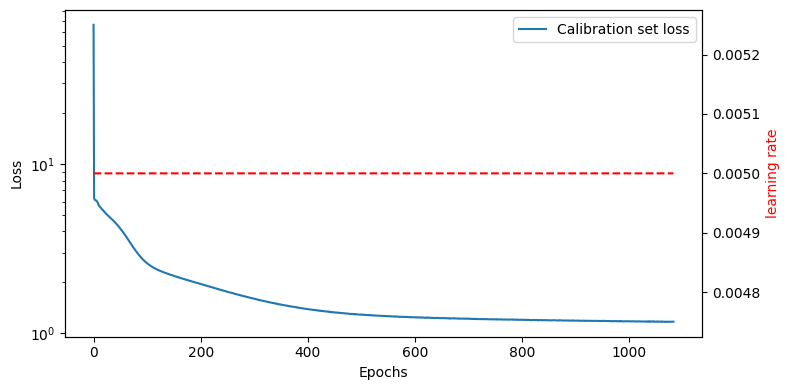

In [7]:
peval.plot_model_history(history.history)

## Test Model

In [8]:
df_preds = df[descriptive_cols].copy()
df_preds["y_true"] = df_preds["dry_matter"]
df_preds["y_pred"] = model.predict(df[x_cols])
df_preds

2639/2639 [==============================] - 3s 1ms/step


,partition,train_partition,subsequent_flag_1,sample_order_1,origin,population,date,season,region,cultivar,physio_stage,temp,reference_no,dry_matter,instrument,spectra_no,y_true,y_pred
36003,train,calibration,0,0,nich,105400,2017-09-27,2017,NT,r2e2,green,undef,3287,12.327440,17033,36945,12.327440,13.307133
45363,train,calibration,0,1,nich,107200,2017-10-23,2017,NT,r2e2,green,undef,4039,14.638310,15016,46563,14.638310,14.104290
43757,train,calibration,0,3,nich,106800,2017-10-23,2017,NT,hg,green,undef,3876,15.665600,15016,44933,15.665600,14.629025
23699,train,tunning,0,4,nich,103107,2016-10-14,2016,NT,r2e2,ripen,undef,1919,15.031000,15023,24705,15.031000,15.485081
72520,validation,calibration,1,5,nich,112700,2019-03-09,2018,QLD,keitt,ripen,high,7667,16.867996,15006,80282,16.867996,17.496922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71544,validation,calibration,1,84966,nich,112500,2019-03-04,2018,QLD,caly,ripen,undef,7558,14.563697,18029,77214,14.563697,14.650410
16397,train,calibration,0,84967,nich,102503,2016-09-03,2016,NT,kp,ripen,undef,1271,17.370000,30004,17241,17.370000,17.294746
12562,train,tunning,0,84968,nich,101200,2015-11-02,2015,NT,caly,green,high,498,18.820072,15023,13824,18.820072,18.394001
58787,anderson_external_val,calibration,0,84969,published,109700,2018-08-07,2018,NT,caly,ripen,undef,5341,17.306802,15006,60441,17.306802,17.153896


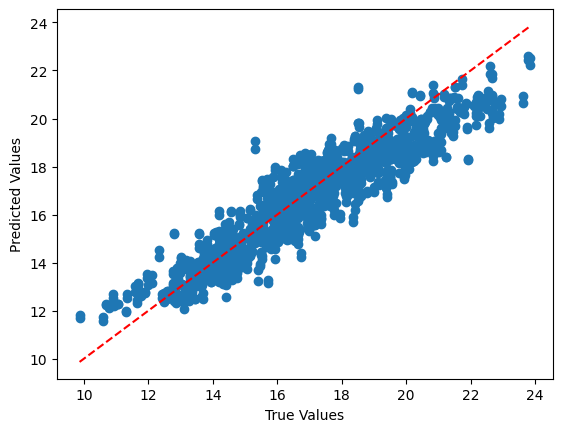

{'r2': 0.8565892195219762,
 'rmse': 1.0105861959058762,
 'sep': 0.9666670221316614,
 'bias': 0.2957780632743143,
 'rpd': 2.761566937400355}

In [9]:
test_partition = df_preds.query("partition == 'validation'")
metrics = peval.calculate_metrics(y_true=test_partition["y_true"], y_pred=test_partition["y_pred"])
metrics

## Output predictions and metrics

In [10]:
df_preds.to_pickle(f"data/predictions/model_2.pkl")
with open(f"data/metrics/model_2.pkl", "wb") as f:
    pickle.dump(metrics, f)